# Solving the $\mathbb{q}^\top$ integral

In this notebook we validate our expressions for the vector $\mathbb{q}^\top$.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from IPython.display import Latex
from scipy.special import binom

np.seterr(invalid="ignore", divide="ignore");

## Limits of integration

In the paper, we presented the expressions for the point of intersection between the limb of the occulted body and the terminator and between the limb of the occulted body and the limb of the occultor, both parametrized in terms of the angle $\lambda$:

In [16]:
def compute_lam(b, theta, bo, ro):
    """
    Return the limits of integration for the qT integral.
    
    Note that we're in the F' frame, so theta is actually theta'.
    """
    # Intersection with the terminator
    if np.cos(theta) ** 2 + (np.sin(theta) - bo) ** 2 < ro ** 2:
        lam0 = theta
    else:
        lam0 = theta + np.pi
    
    # Intersection with the occultor
    sign = np.array([1, -1])
    lam1 = 0.5 * np.pi + sign * (
        np.arcsin((1 - ro ** 2 + bo ** 2) / (2 * bo)) - 0.5 * np.pi
    )
    
    # Keep only the dayside point
    x = np.cos(lam1)
    y = np.sin(lam1)
    xr = x * np.cos(theta) + y * np.sin(theta)
    yr = -x * np.sin(theta) + y * np.cos(theta)
    term = 1 - xr ** 2
    yt = b * np.sqrt(term)
    dayside = yr >= yt
    lam1 = lam1[dayside][0]

    return np.array([lam0, lam1])

Let's verify that these expressions give us the correct points of intersection for the example in Figure 16:

In [12]:
def plot(b, theta, bo, ro, lam):
    """Plot the occultor, the occulted body, and the day/night terminator in frame F'."""
    # Equation of a rotated ellipse
    x0 = np.linspace(-1, 1, 1000)
    y0 = b * np.sqrt(1 - x0 ** 2)
    x = x0 * np.cos(theta) - y0 * np.sin(theta)
    y = x0 * np.sin(theta) + y0 * np.cos(theta)

    # Plot the curves
    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.add_artist(plt.Circle((0, 0), 1, ec="k", fc="none"))
    ax.add_artist(plt.Circle((0, bo), ro, ec="k", fc="none"))
    ax.plot(x, y)

    # Indicate the angles
    ax.plot(0, 0, "k.")
    ax.plot([0, 1], [0, 0], "k--", lw=1)
    for i, lam_i in enumerate(lam):
        
        ax.plot(
            [0, np.cos(lam_i)],
            [0, np.sin(lam_i)],
            color="k",
            lw=1,
        )
        ax.plot(
            [np.cos(lam_i)],
            [np.sin(lam_i)],
            "C1o"
        )

    # Appearance
    ax.set_aspect(1)
    ax.set_xlim(-1.01, 1.01)
    ax.set_ylim(-1.01, 1.25)
    ax.axis("off")
    return ax

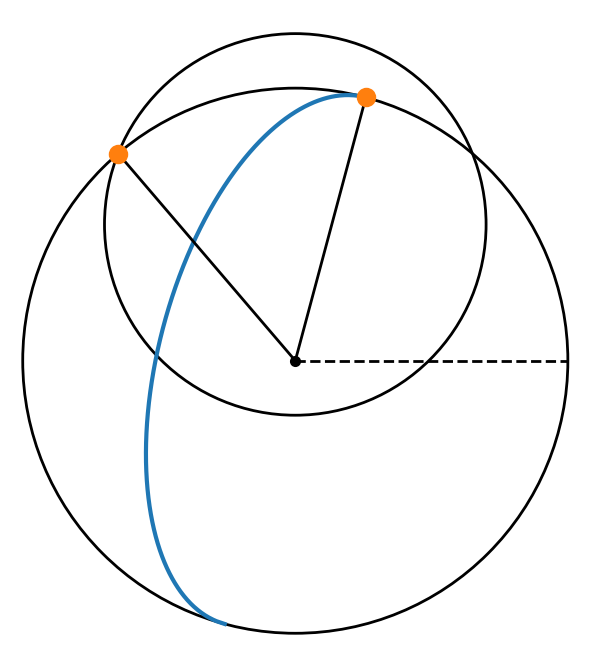

In [17]:
# input
b = 0.5
theta = 75 * np.pi / 180
bo = 0.5
ro = 0.7

# compute the angles
lam = compute_lam(b, theta, bo, ro)

# Plot
ax = plot(b, theta, bo, ro, lam);

The angle $\lambda$ is measured counter-clockwise from the $x'$-axis, along the unit disk.

Here are the two angles for future reference:

In [18]:
for i in range(2):
    display(Latex(r"${:.2f}^\circ$".format(lam[i] * 180 / np.pi)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Numerical evaluation

Now that we can compute `lam`, let's borrow some code from [Greens.ipynb](Greens.ipynb), where we showed how to evaluate $\mathbb{q}^\top$ numerically via Green's theorem. We'll compare our analytic solution to this numerical version.

In [29]:
def G(n):
    """
    Return the anti-exterior derivative of the nth term of the Green's basis.
    This is a two-dimensional (Gx, Gy) vector of functions of x and y.
    
    """
    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - y ** 2)))

    if nu % 2 == 0:
        
        G = [lambda x, y: 0, lambda x, y: x ** (0.5 * (mu + 2)) * y ** (0.5 * nu)]
    
    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):
        
        G = [lambda x, y: x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]
    
    elif (mu == 1) and (l % 2 != 0):
        
        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]
    
    else:
        
        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * y ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]
        
    return G

def primitive(x, y, dx, dy, theta1, theta2, n=0):
    """A general primitive integral computed numerically."""

    def func(theta):
        Gx, Gy = G(n)
        return Gx(x(theta), y(theta)) * dx(theta) + Gy(x(theta), y(theta)) * dy(theta)

    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res


def qT_numerical(deg, lam):
    """Compute the qT integral numerically from its integral definition."""
    N = (deg + 1) ** 2
    qT = np.zeros(N)
    for n in range(N):
        for lam1, lam2 in lam.reshape(-1, 2):
            x = lambda lam: np.cos(lam)
            y = lambda lam: np.sin(lam)
            dx = lambda lam: -np.sin(lam)
            dy = lambda lam: np.cos(lam)
            qT[n] += primitive(x, y, dx, dy, lam1, lam2, n)
    return qT

## Analytic evaluation

Now let's code up the expression derived in the paper in terms of the matrix $\mathbb{H}$. We show how to evaluate this matrix analytically in the notebook [H.ipynb](H.ipynb), so here we'll evaluate it numerically for simplicity.

In [30]:
def computeH(umax, vmax, lam):
    """
    The matrix H evaluated by direct numerical integration.
    
    """
    H = np.zeros((umax + 1, vmax + 1))
    for u in range(umax + 1):
        for v in range(vmax + 1):
            for i in range(0, len(lam), 2):
                func = lambda x: np.cos(x) ** u * np.sin(x) ** v
                H[u, v] += quad(func, lam[i], lam[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return H


def qT(deg, lam):
    """
    Compute the qT integral, evaluated in terms of the integral H.
    
    """
    # Initialize
    N = (deg + 1) ** 2
    qT = np.zeros(N) * np.nan

    # Pre-compute the helper integral
    H = computeH(deg + 2, deg + 2, lam)

    for n in range(N):

        # Get the mu, nu indices
        l = int(np.floor(np.sqrt(n)))
        m = n - l * l - l
        mu = l - m
        nu = l + m

        # Cases!
        if mu % 2 == 0:
            
            qT[n] = H[(mu + 4) // 2, nu // 2]
            
        elif mu == nu == 1:
            
            qT[n] = sum(-np.array(lam)[::2] + np.array(lam)[1::2]) / 3.0
            
        else:
            
            qT[n] = 0

    return qT

Finally, let's show that the numerical and analytic expressions agree up to degree 5 for the example in Figure 16:

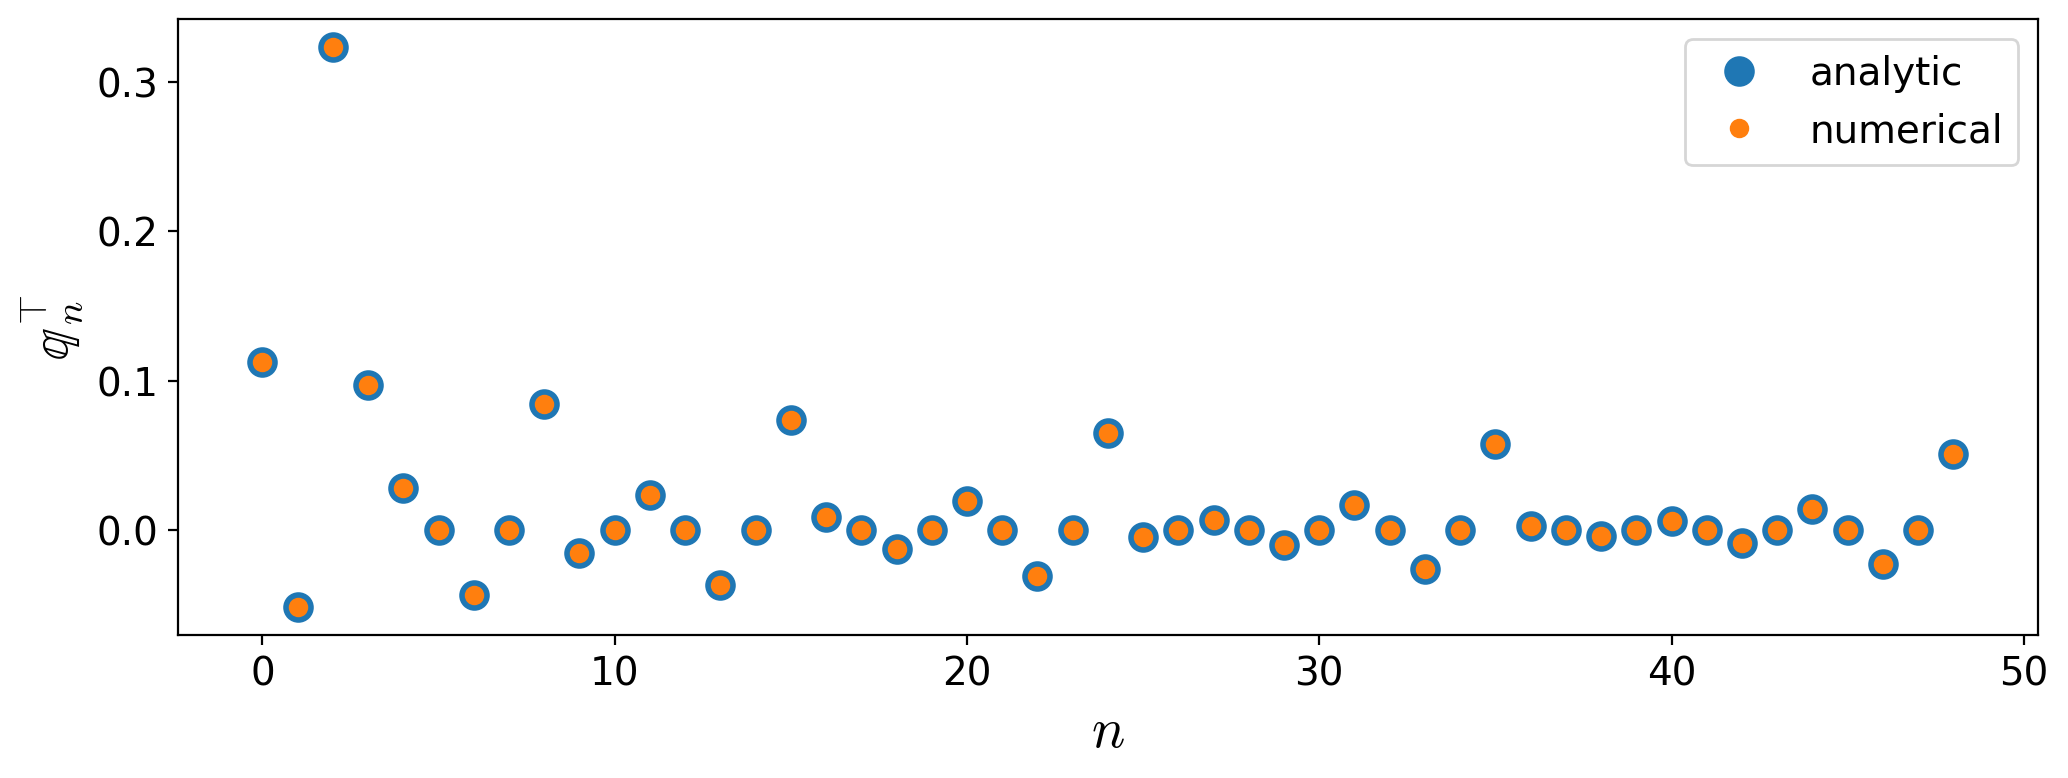

In [31]:
plt.plot(qT(6, lam), "C0o", label="analytic", ms=10)
plt.plot(qT_numerical(6, lam), "C1o", label="numerical")
plt.legend()
plt.xlabel(r"$n$", fontsize=20)
plt.ylabel(r"$\mathbb{q}_n^\top$", fontsize=20);

The error is at the machine level:

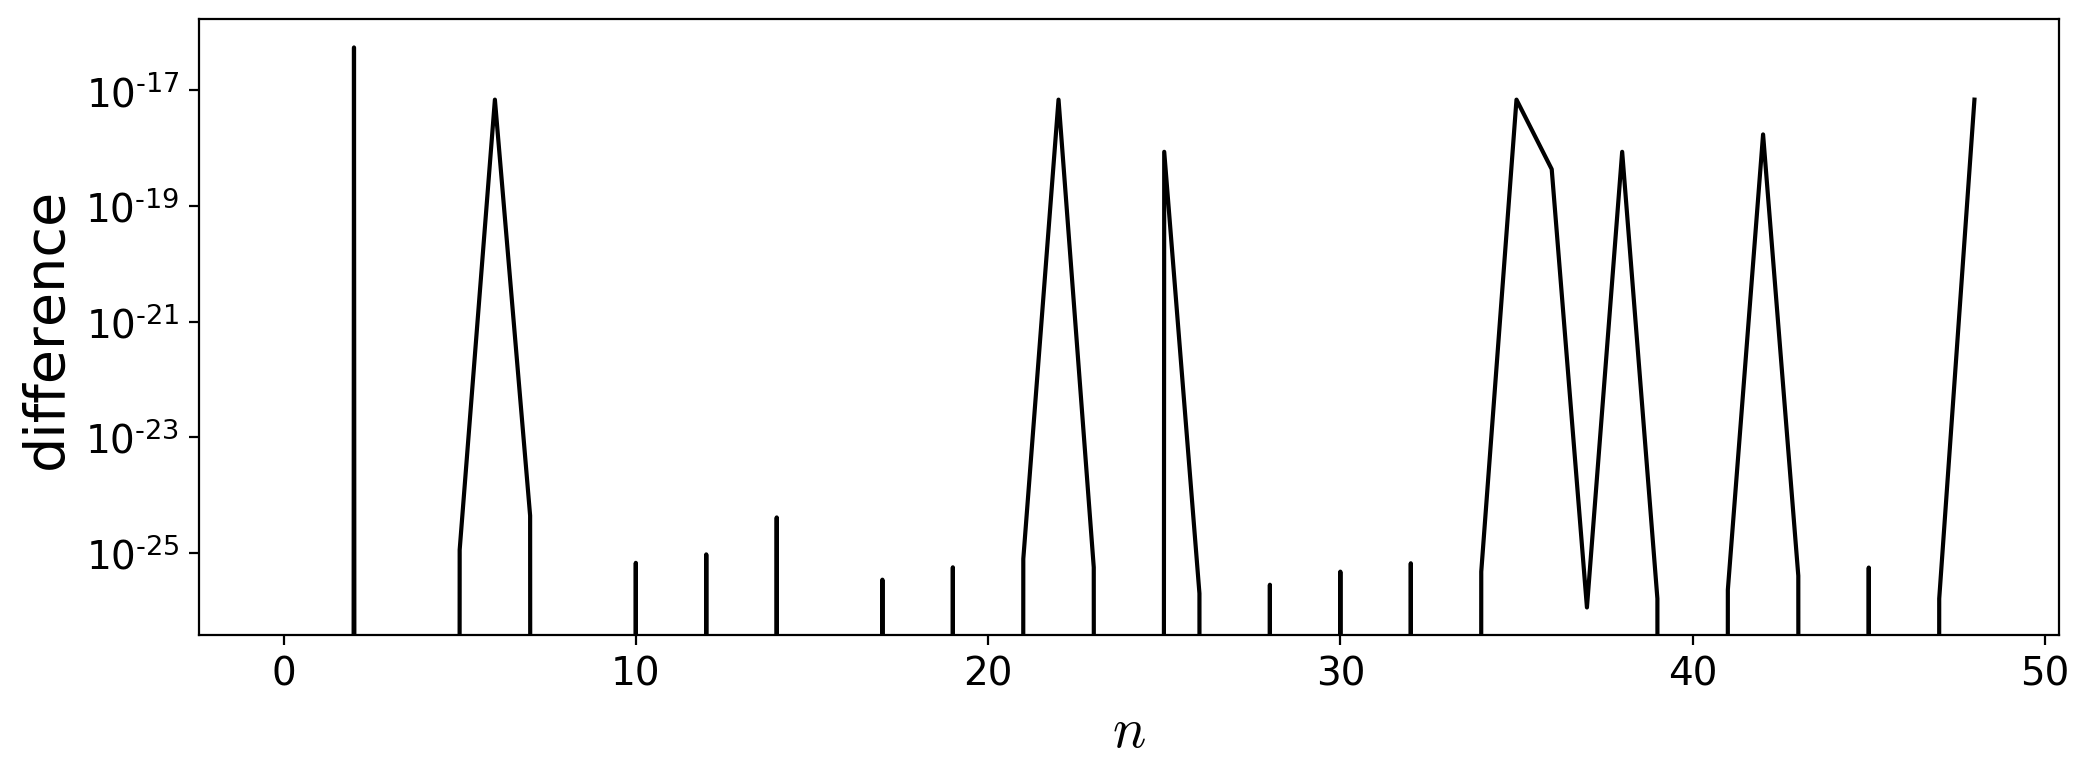

In [32]:
plt.plot(np.abs(qT(6, lam) - qT_numerical(6, lam)), "k-")
plt.xlabel(r"$n$", fontsize=20)
plt.yscale("log")
plt.ylabel(r"difference", fontsize=20);